In [ ]:
!pip uninstall -y bitsandbytes torch transformers accelerate peft datasets


!pip install -q "torch>=2.1" torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

!pip install -q transformers accelerate peft datasets

!pip install -q bitsandbytes

!echo "--- Installed Versions ---"
!pip list | grep -E "torch|transformers|accelerate|peft|datasets|bitsandbytes"
!echo "------------------------"

import torch
import bitsandbytes
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"bitsandbytes version: {bitsandbytes.__version__}")
try:
    linear = bitsandbytes.nn.Linear4bit(10, 10, compute_dtype=torch.float16, compress_statistics=True, quant_type='nf4')
    print("bitsandbytes CUDA check PASSED (dummy layer created).")
except Exception as e:
    print(f"bitsandbytes CUDA check FAILED: {e}")
    print("WARNING: bitsandbytes might still lack GPU support!")


from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

print("Loading dataset...")
dataset = load_dataset('json', data_files='scad_pretraining_dataset_1000.json')

def format_example(example):
    return {
        "text": f"### Instruction: {example['prompt']}\n### Input: {example['input']}\n### Output: {example['output']}"
    }

dataset = dataset.map(format_example)

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: transformers 4.51.3
Uninstalling transformers-4.51.3:
  Successfully uninstalled transformers-4.51.3
Found existing installation: accelerate 1.6.0
Uninstalling accelerate-1.6.0:
  Successfully uninstalled accelerate-1.6.0
Found existing installation: peft 0.15.2
Uninstalling peft-0.15.2:
  Successfully uninstalled peft-0.15.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 597.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 92.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 106.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 740.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:


import zipfile
import os

zip_file_1 = '/content/scad_finetuned.zip' 
zip_file_2 = '/content/scad_finetuned_final.zip'

extract_folder_1 = os.path.join('/content/', os.path.splitext(os.path.basename(zip_file_1))[0])
extract_folder_2 = os.path.join('/content/', os.path.splitext(os.path.basename(zip_file_2))[0])

os.makedirs(extract_folder_1, exist_ok=True)
os.makedirs(extract_folder_2, exist_ok=True)

with zipfile.ZipFile(zip_file_1, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_1)

with zipfile.ZipFile(zip_file_2, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_2)

print(f"Files extracted to {extract_folder_1}")
print(f"Files extracted to {extract_folder_2}")

Files extracted to /content/scad_finetuned
Files extracted to /content/scad_finetuned_final


In [ ]:
from peft import PeftModel
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch

tokenizer = AutoTokenizer.from_pretrained("bigcode/starcoder2-7b")
tokenizer.pad_token = tokenizer.eos_token

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

base_model = AutoModelForCausalLM.from_pretrained(
    "bigcode/starcoder2-7b",
    quantization_config=bnb_config,
    torch_dtype=torch.float16,
    device_map="auto"
)


model = PeftModel.from_pretrained(base_model, "./scad_finetuned_final")
model = model.merge_and_unload()



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.88k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/777k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/442k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.06M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/893 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/41.6k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.89G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.51G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/bnb.py:351: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


In [ ]:
def modify_scad_code(original_code: str, instruction: str) -> str:
    """
    Sends a SCAD‐only prompt, then extracts the OpenSCAD result.
    """
    prompt = f"""You are a SCAD transformer.
    Only produce valid OpenSCAD code—no Python, no images, no commentary.

    ### Instruction:
    {instruction}

    ### Input (OpenSCAD):
    ```scad
    {original_code}
    """
    print("Prompt sent:\n", prompt)

    inputs  = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=1024,
        do_sample=False,
        temperature=0.2,
        pad_token_id=tokenizer.eos_token_id,
    )
    raw = tokenizer.decode(outputs[0], skip_special_tokens=True)
    if "```scad" in raw:
        return raw.split("```scad")[-1].rsplit("```",1)[0].strip()
    return raw.strip()

In [ ]:
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import OrderedDict

def extract_polygons(code: str) -> OrderedDict:
    """
    Parse module definitions and return an ordered dict module_name -> list of [x,y] points.
    Handles trailing commas in polygon definitions.
    """
    modules = {}
    for m in re.finditer(r'module\s+(\w+)\s*\([^)]*\)\s*\{([^}]*)\}', code, re.DOTALL):
        name, body = m.group(1), m.group(2)
        poly_m = re.search(r'polygon\s*\(\s*(\[\[.*?\]\s*,?\s*\])\s*\)\s*;', body, re.DOTALL)
        if poly_m:
            try:
                pts = eval(poly_m.group(1))
                modules[name] = pts
            except Exception:
                continue

    invoked = re.findall(r'^\s*(\w+)\s*\(\);', code, re.MULTILINE)
    return OrderedDict((n, modules[n]) for n in invoked if n in modules)

def extract_colors(code: str) -> dict:
    """
    Parse color("#RRGGBB") for each module invocation.
    """
    bodies = {m.group(1): m.group(2)
              for m in re.finditer(r'module\s+(\w+)\s*\([^)]*\)\s*\{([^}]*)\}',
                                   code, re.DOTALL)}
    invoked = re.findall(r'^\s*(\w+)\s*\(\);', code, re.MULTILINE)
    colors = {}
    for n in invoked:
        body = bodies.get(n, "")
        c = re.search(r'color\s*\(\s*"(#(?:[0-9A-Fa-f]{6}))"\s*\)', body)
        if c:
            colors[n] = c.group(1)
    return colors

def render_scad_code(code: str, padding: int = 10, image_size: tuple = (512, 512)):
    """
    Auto-scale and render SCAD polygons in their colors.
    """
    polys = extract_polygons(code)
    colors = extract_colors(code)

    if not polys:
        print("No polygons found in SCAD code.")
        return

    all_x = [pt[0] for pts in polys.values() for pt in pts]
    all_y = [pt[1] for pts in polys.values() for pt in pts]
    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)
    width, height = max_x - min_x, max_y - min_y

    sx = (image_size[0] - 2*padding) / width if width else 1.0
    sy = (image_size[1] - 2*padding) / height if height else 1.0
    scale = min(sx, sy)

    canvas = np.ones((image_size[1], image_size[0], 3), dtype=np.uint8) * 255

    for name, pts in polys.items():
        hexcol = colors.get(name, "#CCCCCC").lstrip('#')
        bgr = tuple(int(hexcol[i:i+2], 16) for i in (4,2,0))
        mapped = [
            (
                int((pt[0] - min_x) * scale + padding),
                int((pt[1] - min_y) * scale + padding)
            ) for pt in pts
        ]
        pts_np = np.array(mapped, dtype=np.int32)
        cv2.fillPoly(canvas, [pts_np], bgr)

    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


current_code = """
module room_type_0() {  color("#FFA500")  polygon([[56, 48],[56, 111],[119, 111],[119, 48],]); }
room_type_0();

module room_type_1() {  color("#FFD700")  polygon([[120, 48],[120, 111],[163, 111],[163, 48],]); }
room_type_1();

module room_type_2() {  color("#6B8E23")  polygon([[164, 48],[164, 71],[195, 71],[195, 48],]); }
room_type_2();

module room_type_3() {  color("#F08080")  polygon([[164, 164],[164, 191],[195, 191],[195, 164],]); }
room_type_3();

module room_type_4() {  color("#ADD8E6")  polygon([[164, 136],[164, 163],[195, 163],[195, 136],]); }
room_type_4();

module room_type_5() {  color("#FFD700")  polygon([[56, 164],[56, 191],[119, 191],[119, 164],]); }
room_type_5();

module room_type_6() {  color("#EEE8AA")  polygon([[56, 112],[56, 163],[119, 163],[120, 164],[120, 191],[163, 191],[163, 136],[164, 135],[195, 135],[195, 112],]); }
room_type_6();
"""


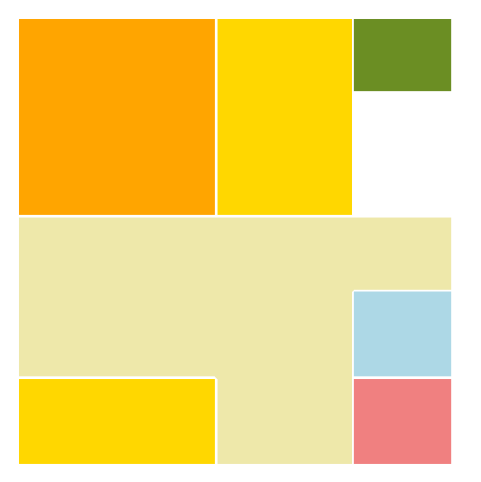

In [21]:
render_scad_code(current_code)


Prompt sent:
 You are a SCAD transformer.
    Only produce valid OpenSCAD code—no Python, no images, no commentary.

    ### Instruction:
    Scale module room_type_1 uniformly by 2

    ### Input (OpenSCAD):
    ```scad
    
module room_type_0() {  color("#FFA500")  polygon([[56, 48],[56, 111],[119, 111],[119, 48],]); }
room_type_0();

module room_type_1() {  color("#FFD700")  polygon([[120, 48],[120, 111],[163, 111],[163, 48],]); }
room_type_1();

module room_type_2() {  color("#6B8E23")  polygon([[164, 48],[164, 71],[195, 71],[195, 48],]); }
room_type_2();

module room_type_3() {  color("#F08080")  polygon([[164, 164],[164, 191],[195, 191],[195, 164],]); }
room_type_3();

module room_type_4() {  color("#ADD8E6")  polygon([[164, 136],[164, 163],[195, 163],[195, 136],]); }
room_type_4();

module room_type_5() {  color("#FFD700")  polygon([[56, 164],[56, 191],[119, 191],[119, 164],]); }
room_type_5();

module room_type_6() {  color("#EEE8AA")  polygon([[56, 112],[56, 163],[119, 163],[1

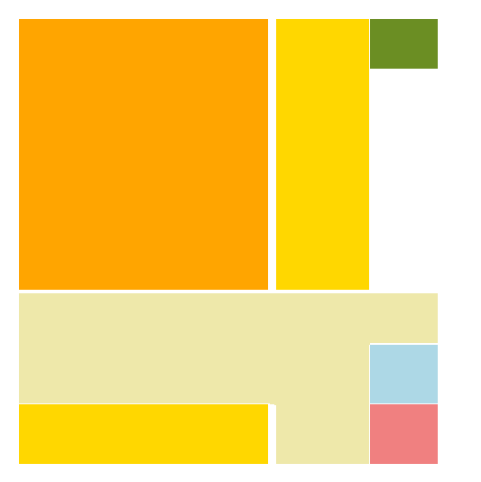

module room_type_0() {  color("#FFA500")  polygon([[112, 96],[112, 222],[228, 222],[228, 96],]); }
room_type_0();

module room_type_1() {  color("#FFD700")  polygon([[232, 96],[232, 222],[275, 222],[275, 96],]); }
room_type_1();

module room_type_2() {  color("#6B8E23")  polygon([[276, 96],[276, 119],[307, 119],[307, 96],]); }
room_type_2();

module room_type_3() {  color("#F08080")  polygon([[276, 276],[276, 303],[307, 303],[307, 276],]); }
room_type_3();

module room_type_4() {  color("#ADD8E6")  polygon([[276, 248],[276, 275],[307, 275],[307, 248],]); }
room_type_4();

module room_type_5() {  color("#FFD700")  polygon([[112, 276],[112, 303],[228, 303],[228, 276],]); }
room_type_5();

module room_type_6() {  color("#EEE8AA")  polygon([[112, 224],[112, 275],[228, 275],[232, 276],[232, 303],[275, 303],[275, 248],[276, 247],[307, 247],[307, 224],]); }
room_type_6();

    
```

    ### Output (SVG):


In [29]:
instr = (
    "Scale module room_type_1 uniformly by 2"
)
modified = modify_scad_code(current_code, instr)
render_scad_code(modified)
print(modified)

In [ ]:
# Agent runner

while True:
    print("\nCurrent Code:\n", current_code)
    instruction = input("Enter instruction: ")

    if instruction.lower() in ["exit", "quit"]:
        print("Exiting.")
        break

    try:
        updated_code = modify_scad_code(current_code, instruction)
        render_scad_code(updated_code)
        current_code = updated_code  
        print("Code updated!")
    except Exception as e:
        print("Error:", e)